In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchvision.transforms import functional as TF
from PIL import Image, ImageDraw
import os
import re

def crop_lattice(img):
    return TF.crop(img, top=58, left=143, height=370, width=370)

def mask_temp_box_pil(img):
    draw = ImageDraw.Draw(img)
    draw.rectangle([16, 44, 16+148, 44+16], fill="black")
    return img

class IsingFolderDataset(Dataset):
    def __init__(self, data_dir, flatten=True, transform=None):
        self.samples = []
        self.flatten = flatten
        self.transform = transform or transforms.Compose([
            transforms.Lambda(crop_lattice),
            transforms.Lambda(mask_temp_box_pil),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x * 2 - 1)
        ])
        temp_pat = re.compile(r'Temp=(\d+)-(\d+)')
        for folder in os.listdir(data_dir):
            folder_path = os.path.join(data_dir, folder)
            if not os.path.isdir(folder_path): continue
            m = temp_pat.match(folder)
            if m:
                temp = float(m.group(1) + "." + m.group(2))
                label = 0 if temp < 2.0 else 1 if temp < 2.5 else 2
                for fname in os.listdir(folder_path):
                    if fname.endswith(".png"):
                        self.samples.append((os.path.join(folder_path, fname), label))

    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path)
        x = self.transform(img)
        if self.flatten:
            x = x.view(-1)
        return x, torch.tensor(label).long()

def get_image_dataloaders(data_dir, batch_size=32, train_ratio=0.8, flatten=True, shuffle=True, seed=42):
    ds = IsingFolderDataset(data_dir, flatten=flatten)
    train_len = int(train_ratio * len(ds))
    test_len = len(ds) - train_len
    train_ds, test_ds = random_split(ds, [train_len, test_len], generator=torch.Generator().manual_seed(seed))
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=shuffle)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2)  # [B,32,370,370]
        self.pool1 = nn.MaxPool2d(2, 2)                                    # [B,32,185,185]
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2) # [B,64,185,185]
        self.pool2 = nn.MaxPool2d(2, 2)                                    # [B,64,92,92]
        self.fc1 = nn.Linear(64 * 92 * 92, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Epoch 1 completed.
Test Accuracy: 98.85%
Epoch 2 completed.
Test Accuracy: 100.00%
Epoch 3 completed.
Test Accuracy: 100.00%
Epoch 4 completed.
Test Accuracy: 100.00%
Epoch 5 completed.
Test Accuracy: 100.00%
Epoch 6 completed.
Test Accuracy: 100.00%
Epoch 7 completed.
Test Accuracy: 100.00%
Epoch 8 completed.
Test Accuracy: 100.00%
Epoch 9 completed.
Test Accuracy: 100.00%
Epoch 10 completed.
Test Accuracy: 100.00%


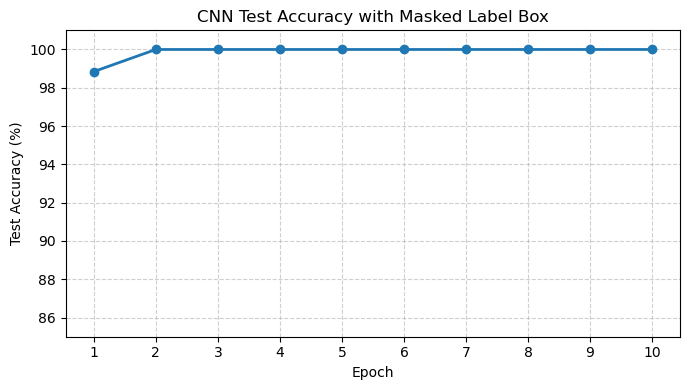

CNN_accuracy_plot saved as results/cnn_accuracy_plot.png


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import os

def train_cnn(epochs=10, batch_size=32, lr=1e-3, device='mps'):
    train_loader, test_loader = get_image_dataloaders("../data", batch_size=batch_size, flatten=False)
    model = CNNModel(num_classes=3).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    test_accuracy = []
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            loss = criterion(out, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1} completed.")

        # Evaluate
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb).argmax(dim=1)
                correct += (preds == yb).sum().item()
                total += yb.size(0)
        acc = correct / total
        test_accuracy.append(acc * 100)
        print(f"Test Accuracy: {acc*100:.2f}%")

    os.makedirs("results", exist_ok=True)
    plt.figure(figsize=(7, 4))
    plt.plot(range(1, len(test_accuracy)+1), test_accuracy, marker='o', linewidth=2)
    plt.xticks(range(1, len(test_accuracy)+1))
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy (%)')
    plt.title('CNN Test Accuracy with Masked Label Box')
    plt.ylim(85, 101)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig("results/cnn_accuracy_plot.png")
    plt.show()
    print("CNN_accuracy_plot saved as results/cnn_accuracy_plot.png")

if __name__ == "__main__":
    train_cnn()